In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.patches import Polygon
from scipy.spatial import Delaunay

In [2]:
"""
This Jupyter cell is based on code from:
https://github.com/ijmbarr/images-to-triangles
"""

def edge_points(img, length_scale=200,n_horizontal_points=None,n_vertical_points=None):
    """
    Returns points around the edge of an image.
    :param image: image array
    :param length_scale: how far to space out the points if no
                         fixed number of points is given
    :param n_horizontal_points: number of points on the horizonal edge.
                                Leave as None to use lengthscale to determine
                                the value
    :param n_vertical_points: number of points on the horizonal edge.
                                Leave as None to use lengthscale to determine
                                the value
    :return: array of coordinates
    """
    ymax, xmax = img.shape[:2]

    if n_horizontal_points is None:
        n_horizontal_points = int(xmax / length_scale)

    if n_vertical_points is None:
        n_vertical_points = int(ymax / length_scale)

    delta_x = xmax / n_horizontal_points
    delta_y = ymax / n_vertical_points

    return np.array(
        [[0, 0], [xmax, 0], [0, ymax], [xmax, ymax]]
        + [[delta_x * i, 0] for i in range(1, n_horizontal_points)]
        + [[delta_x * i, ymax] for i in range(1, n_horizontal_points)]
        + [[0, delta_y * i] for i in range(1, n_vertical_points)]
        + [[xmax, delta_y * i] for i in range(1, n_vertical_points)]
    )


def generate_random_points(img, num_points=100):
    """
    Generates a set of uniformly distributed points over the area of image
    :param image: image as an array
    :param n_points: int number of points to generate
    :return: array of points
    """
    ymax, xmax = img.shape[:2]
    points = np.random.uniform(size=(num_points, 2))
    points *= np.array([xmax, ymax])
    points = np.concatenate([points, edge_points(img)])
    return points

def get_triangle_colour(triangles, image, agg_func=np.median):
    """
    Get's the colour of a triangle, based on applying agg_func to the pixels
    under it
    :param triangles: scipy.spatial.Delaunay
    :param image: image as array
    :param agg_func: function
    :return: colour list
    """
    # create a list of all pixel coordinates
    ymax, xmax = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(xmax), np.arange(ymax))
    pixel_coords = np.c_[xx.ravel(), yy.ravel()]

    # for each pixel, identify which triangle it belongs to
    triangles_for_coord = triangles.find_simplex(pixel_coords)

    df = pd.DataFrame({
        "triangle": triangles_for_coord,
        "r": image.reshape(-1, 3)[:, 0],
        "g": image.reshape(-1, 3)[:, 1],
        "b": image.reshape(-1, 3)[:, 2]
    })

    n_triangles = triangles.vertices.shape[0]

    by_triangle = (
        df
            .groupby("triangle")
        [["r", "g", "b"]]
            .aggregate(agg_func)
            .reindex(range(n_triangles), fill_value=0)
        # some triangles might not have pixels in them
    )

    return by_triangle.values

def set_axis_defaults(ax):
    """
    Set's some defaults for a matplotlib ax
    :param ax: ax to change
    :return: None
    """
    ax.axis("off")
    ax.axis("tight")
    ax.set_aspect("equal")
    ax.autoscale(False)


def draw_image(ax, image):
    """
    Plots image to an ax
    :param ax: matplotlib axis
    :param image: image in array form
    :return: None
    """
    ax.imshow(image)


def draw_points(ax, points):
    """
    Plots a set of points on an ax
    :param ax: ax
    :param points: array of (x,y) coordinates
    :return: None
    """
    ax.scatter(x=points[:, 0], y=points[:, 1], color="k", s=1.5)


def draw_triangles(ax, points, vertices, colours=None, **kwargs):
    """
    Draws a set of triangles on axis
    :param ax: ax
    :param points: array of (x,y) coordinates
    :param vertices: an array of the vertices of the triangles, indexing the array points
    :param colours: colour of the faces, set as none just to plot the outline
    :param kwargs: kwargs passed to Polygon
    :return: None
    """

    if colours is None:
        face_colours = len(vertices) * ["none"]
        line_colours = len(vertices) * ["black"]
    else:
        face_colours = colours
        line_colours = colours

    for triangle, fc, ec in zip(vertices, face_colours, line_colours):
        p = Polygon([points[i]
                     for i in triangle],
                    closed=True, facecolor=fc,
                    edgecolor=ec, **kwargs)
        ax.add_patch(p)

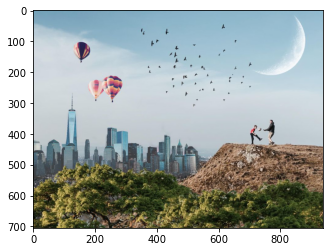

In [17]:
im = plt.imread("balloon.png")  
plt.imshow(im)
# print(im)

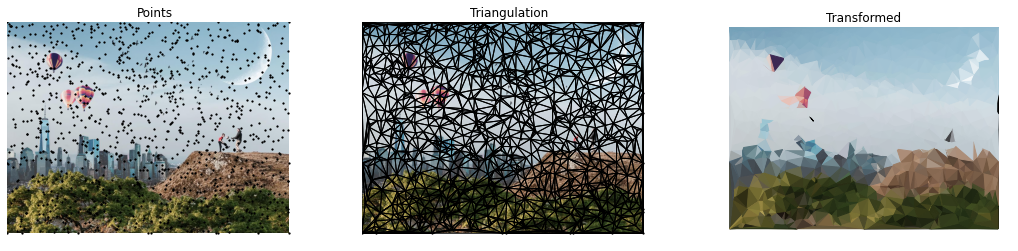

In [18]:
points = generate_random_points(im, num_points=1000)
tri = Delaunay(points)
# print(tri)

fig, axs = plt.subplots(ncols=3, figsize=(18,8), sharey=True)

ax = axs[0]
draw_image(ax, im)
draw_points(ax, points)
ax.set_title("Points")
set_axis_defaults(ax)


ax = axs[1]
draw_image(ax, im)
draw_points(ax, points)
draw_triangles(ax, tri.points, tri.vertices)
ax.set_title("Triangulation")
set_axis_defaults(ax)


ax = axs[2]
triangle_colours = get_triangle_colour(tri, im)
draw_triangles(ax, tri.points, tri.vertices, triangle_colours)
ax.set_title("Transformed")
set_axis_defaults(ax)

In [19]:
positions = []
colors = []

mmax = np.array(tri.points).max()
mmin = np.array(tri.points).min()
ppoints = (2.0*(np.array(tri.points)/mmax)-1.0)*0.75
for triangle, fc in zip(tri.vertices, triangle_colours):
    for i in triangle:
        flipped = ppoints[i].tolist()
        flipped[1]=-(flipped[1]+0.5);
        positions.extend(flipped)
        positions.extend([0])
        colors.extend(fc.tolist())
        colors.extend([1])

with open('balloon.json', 'w') as fp:
    json.dump({'positions': positions, 'colors': colors}, fp)